# Predictive Maintenance: Aircraft Engine RUL Prediction
**Dataset:** NASA C-MAPSS (FD001)

### Objective
Predicting RUL to prevent unexpected failure before it occur, so it might help reduce operational cost.

### Methodology
This project processes historical sensor data to identify degradation patterns. We benchmark three machine learning models to determine the most accurate approach:
1.  **Decision Tree** 
2.  **Random Forest** 
3.  **XGBoost** 

## Dataset

original source:
https://data.nasa.gov/dataset/cmapss-jet-engine-simulated-data

## Import library

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [115]:
index_names = ['unit_nr', 'time_cycles']
op_setting_names = ['os_1', 'os_2', 'os_3']
sensor_names = [f's{i}' for i in range(1, 22)]
col_names = index_names + op_setting_names + sensor_names

## Import dataset

In [116]:
base_path = '/kaggle/input/cmapss-jet-engine-simulated-data/'
train = pd.read_csv(base_path + 'train_FD001.txt', sep='\s+', header=None, names=col_names)
test = pd.read_csv(base_path + 'test_FD001.txt', sep='\s+', header=None, names=col_names)
y_test = pd.read_csv(base_path + 'RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])
print('train', train.shape)
print('test', test.shape)
print('y test', y_test.shape)

train (20631, 26)
test (13096, 26)
y test (100, 1)


In [117]:
display(train.head())

,unit_nr,time_cycles,os_1,os_2,os_3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


## Data preprocessing

Text(0.5, 1.0, 'Missing value in the dataset')

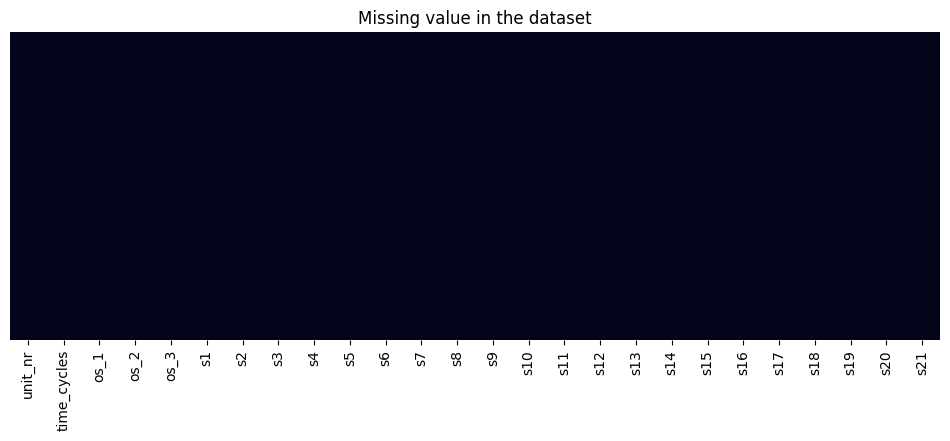

In [118]:
plt.figure(figsize = (12,4))
sns.heatmap(train.isnull(),
            cbar = False,
            yticklabels = False)
plt.title('Missing value in the dataset')

There is no missing value in this dataset

In [119]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
unit_nr,20631.0,51.506568,2.922763e+01,1.0000,26.0000,52.0000,77.0000,100.0000
time_cycles,20631.0,108.807862,6.888099e+01,1.0000,52.0000,104.0000,156.0000,362.0000
os_1,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0015,0.0000,0.0015,0.0087
os_2,20631.0,0.000002,2.930621e-04,-0.0006,-0.0002,0.0000,0.0003,0.0006
os_3,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
s1,20631.0,518.670000,6.537152e-11,518.6700,518.6700,518.6700,518.6700,518.6700
s2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
s3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
s4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
s5,20631.0,14.620000,3.394700e-12,14.6200,14.6200,14.6200,14.6200,14.6200


### feature selection

In [120]:
min_vals = train.min()
max_vals = train.max()

const_cols = min_vals[min_vals == max_vals].index.tolist()

print("min = max column :", const_cols)

# min equal max

min = max column : ['os_3', 's1', 's5', 's10', 's16', 's18', 's19']


In [121]:
train = train.drop(columns=const_cols) 
test = test.drop(columns=const_cols)

print(f"1. Shape: {train.shape}")

1. Shape: (20631, 19)


consider s6 most of value in 25% 50% 75% is the same but out of min max detect

In [122]:
train = train.drop(columns=['s6']) 
test = test.drop(columns=['s6'])

In [123]:
max_cycle = train.groupby('unit_nr')['time_cycles'].max().reset_index()
max_cycle.columns = ['unit_nr', 'max_cycle']

train = train.merge(max_cycle, on='unit_nr', how='left')

train['RUL'] = train['max_cycle'] - train['time_cycles']

train = train.drop('max_cycle', axis=1)

train['RUL'] = train['RUL'].clip(upper=125)

display(train[['unit_nr', 'time_cycles', 'RUL']].head())

,unit_nr,time_cycles,RUL
0,1,1,125
1,1,2,125
2,1,3,125
3,1,4,125
4,1,5,125


In [124]:
corr_matrix = train.corr()
rul_correlation = corr_matrix['RUL'].abs()

low_corr_features = rul_correlation[rul_correlation < 0.05].index.tolist()

print("low cor", low_corr_features)

low cor ['unit_nr', 'os_1', 'os_2']


In [125]:
if 'unit_nr' in low_corr_features:
    low_corr_features.remove('unit_nr')

print("Final Drop List:", low_corr_features)

Final Drop List: ['os_1', 'os_2']


In [126]:
train_final = train.drop(columns=low_corr_features)
test_final = test.drop(columns=low_corr_features)

In [127]:
print(f"Final Shape: {train_final.shape}")
print(train_final.columns.tolist())

Final Shape: (20631, 17)
['unit_nr', 'time_cycles', 's2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21', 'RUL']


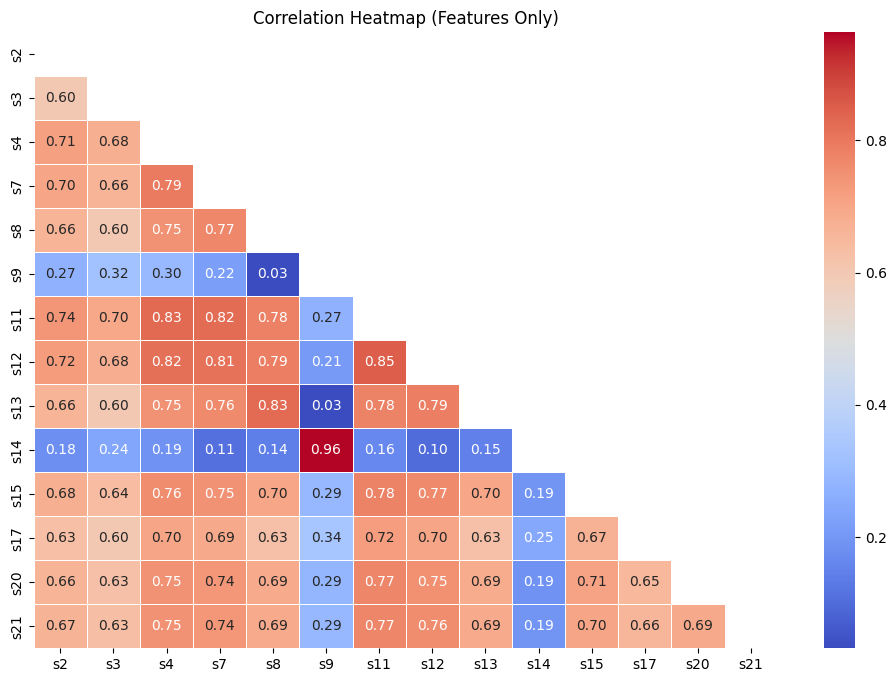

In [128]:
features_only = train_final.drop(columns=['RUL', 'unit_nr', 'time_cycles'], errors='ignore')

df_corr = features_only.corr().abs() 

mask = np.triu(np.ones_like(df_corr, dtype=bool))

plt.figure(figsize=(12, 8))
sns.heatmap(df_corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap (Features Only)')
plt.show()

In [129]:
train_final = train_final.drop(columns=['s14'])
test_final = test_final.drop(columns=['s14'])

In [130]:
print(train_final.shape)

(20631, 16)


In [131]:
train_final = train_final.replace([np.inf, -np.inf], np.nan)

## Eda
sensor info from pdf in src

In [133]:
sensor_info = {
    's1':  {'name': 'Fan Inlet Temp', 'unit': '°R'},
    's2':  {'name': 'LPC Outlet Temp', 'unit': '°R'},
    's3':  {'name': 'HPC Outlet Temp', 'unit': '°R'},
    's4':  {'name': 'LPT Outlet Temp', 'unit': '°R'},
    's5':  {'name': 'Fan Inlet Pressure', 'unit': 'psia'},
    's6':  {'name': 'Bypass Duct Pressure', 'unit': 'psia'},
    's7':  {'name': 'HPC Outlet Pressure', 'unit': 'psia'},
    's8':  {'name': 'Physical Fan Speed', 'unit': 'rpm'},
    's9':  {'name': 'Physical Core Speed', 'unit': 'rpm'},
    's10': {'name': 'Engine Pressure Ratio', 'unit': '-'},
    's11': {'name': 'HPC Outlet Static Pressure', 'unit': 'psia'},
    's12': {'name': 'Ratio of Fuel Flow', 'unit': 'pps/psi'},
    's13': {'name': 'Corrected Fan Speed', 'unit': 'rpm'},
    's14': {'name': 'Corrected Core Speed', 'unit': 'rpm'},
    's15': {'name': 'Bypass Ratio', 'unit': '-'},
    's16': {'name': 'Burner Fuel-Air Ratio', 'unit': '-'},
    's17': {'name': 'Bleed Enthalpy', 'unit': '-'},
    's18': {'name': 'Demanded Fan Speed', 'unit': 'rpm'},
    's19': {'name': 'Demanded Corrected Fan Speed', 'unit': 'rpm'},
    's20': {'name': 'HPT Coolant Bleed', 'unit': 'lbm/s'},
    's21': {'name': 'LPT Coolant Bleed', 'unit': 'lbm/s'}
}

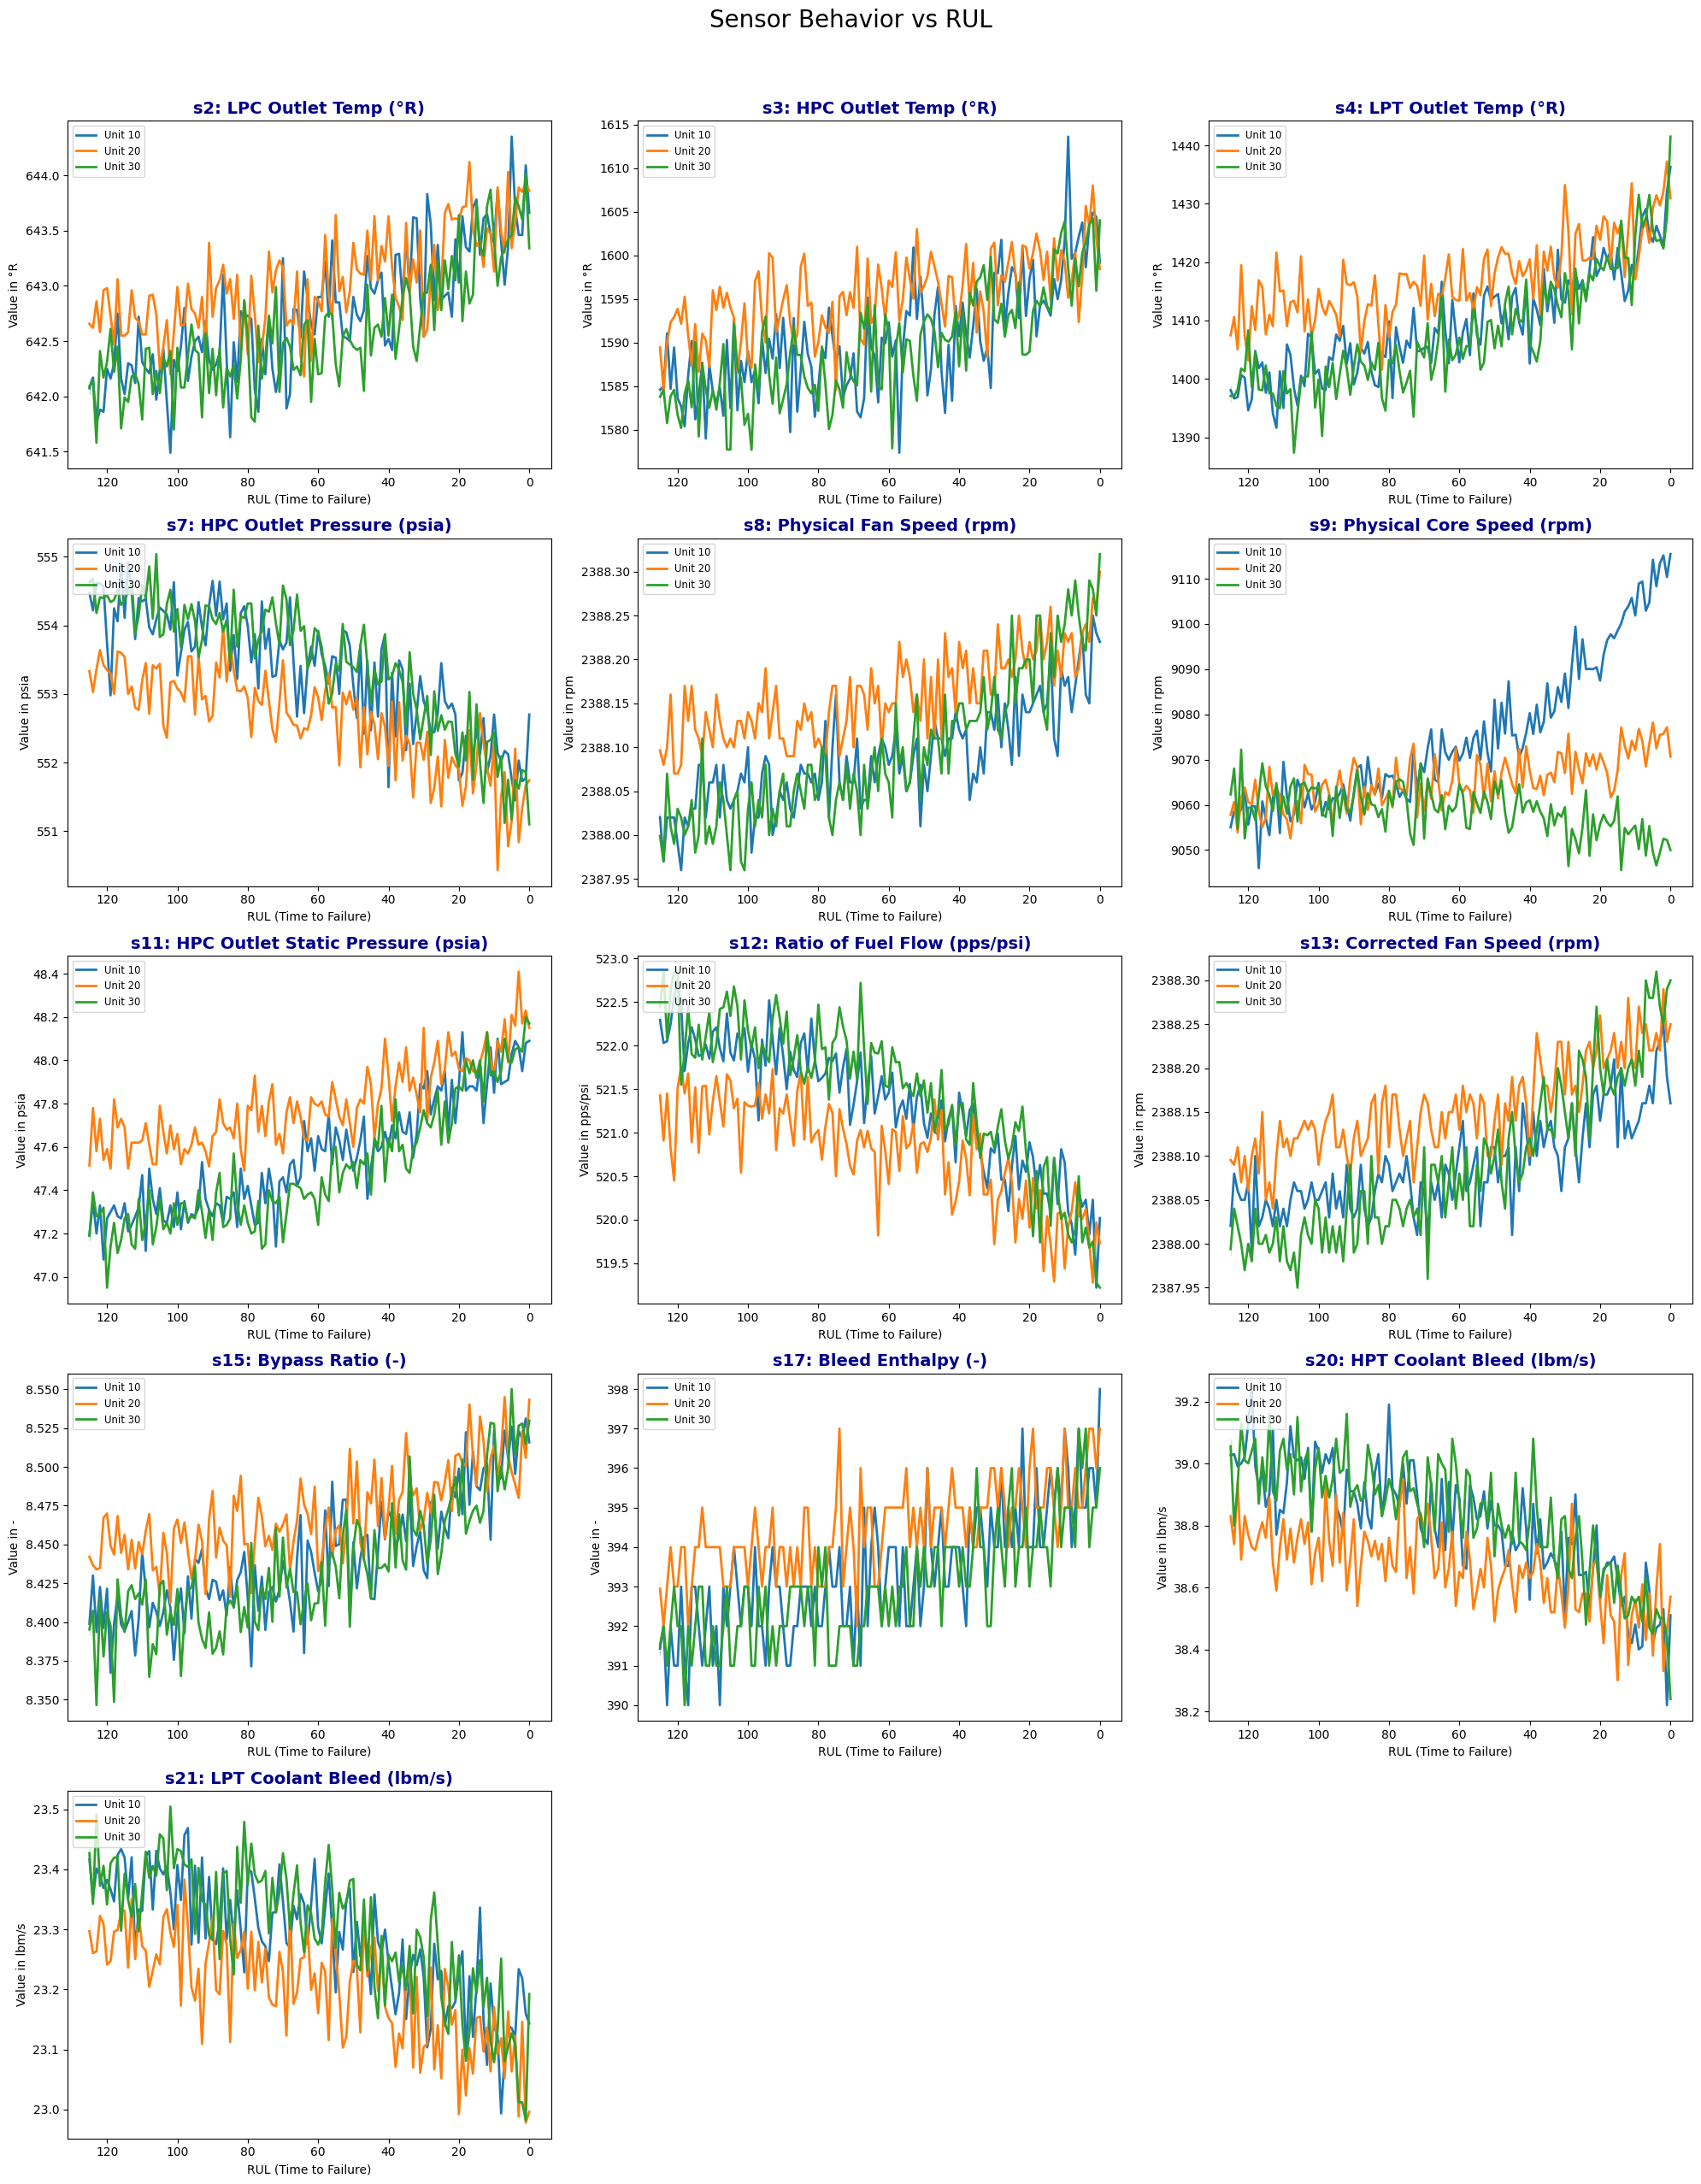

In [135]:
features_to_plot = [col for col in train_final.columns if col not in ['unit_nr', 'time_cycles', 'RUL']]
num_features = len(features_to_plot)

num_cols = 3
num_rows = math.ceil(num_features / num_cols)

plt.figure(figsize=(20, 5 * num_rows))
plt.suptitle('Sensor Behavior vs RUL', fontsize=20, y=1.02)

for i, sensor in enumerate(features_to_plot):
    plt.subplot(num_rows, num_cols, i + 1)
    
    info = sensor_info.get(sensor, {'name': sensor, 'unit': ''})
    title_text = f"{sensor}: {info['name']} ({info['unit']})"
    
    for unit in [10, 20, 30]: 
        data = train_final[train_final['unit_nr'] == unit]
        sns.lineplot(x=data['RUL'], y=data[sensor], label=f'Unit {unit}', linewidth=2)
    
    plt.title(title_text, fontsize=14, fontweight='bold', color='darkblue')
    plt.xlabel('RUL (Time to Failure)')
    plt.ylabel(f"Value in {info['unit']}")
    plt.gca().invert_xaxis()
    plt.legend(loc='upper left', fontsize='small')

plt.tight_layout()
plt.show()

## Model Training

training on three model Decision Tree, Random Forest, XGBoost

In [153]:
features_cols = [c for c in train_final.columns if c not in ['unit_nr', 'time_cycles', 'RUL']]

X_train = train_final[features_cols]
y_train = train_final['RUL']

print("Training Set:")
print("X_train", X_train.shape)
print("y_train", y_train.shape)

test_last_cycle = test_final.groupby('unit_nr').last().reset_index()

X_test = test_last_cycle[features_cols]

y_test_true = y_test['RUL'].clip(upper=125) 

print("\nTesting Set:")
print("X_test", X_test.shape)
print("y_test", y_test_true.shape)


Training Set:
X_train (20631, 13)
y_train (20631,)

Testing Set:
X_test (100, 13)
y_test (100,)


In [172]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

In [173]:
results = []

### Decision Tree

In [174]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
# metric
rmse_dt = np.sqrt(mean_squared_error(y_test_true, y_pred_dt))
r2_dt = r2_score(y_test_true, y_pred_dt)

results.append({'Model': 'Decision Tree', 'RMSE': rmse_dt, 'R2': r2_dt})

### Random Forest

In [175]:
rf = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
# metric
rmse_rf = np.sqrt(mean_squared_error(y_test_true, y_pred_rf))
r2_rf = r2_score(y_test_true, y_pred_rf)

results.append({'Model': 'Random Forest', 'RMSE': rmse_rf, 'R2': r2_rf})

### XGBoost

In [176]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=6)
xg_reg.fit(X_train, y_train)
y_pred_xgb = xg_reg.predict(X_test)
# metric
rmse_xgb = np.sqrt(mean_squared_error(y_test_true, y_pred_xgb))
r2_xgb = r2_score(y_test_true, y_pred_xgb)
results.append({'Model': 'XGBoost', 'RMSE': rmse_xgb, 'R2': r2_xgb})

## Result

In [177]:
df_results = pd.DataFrame(results)
display(df_results)

,Model,RMSE,R2
0,Decision Tree,24.155124,0.636664
1,Random Forest,17.369574,0.812125
2,XGBoost,16.782027,0.824620


### XGBoost Graph

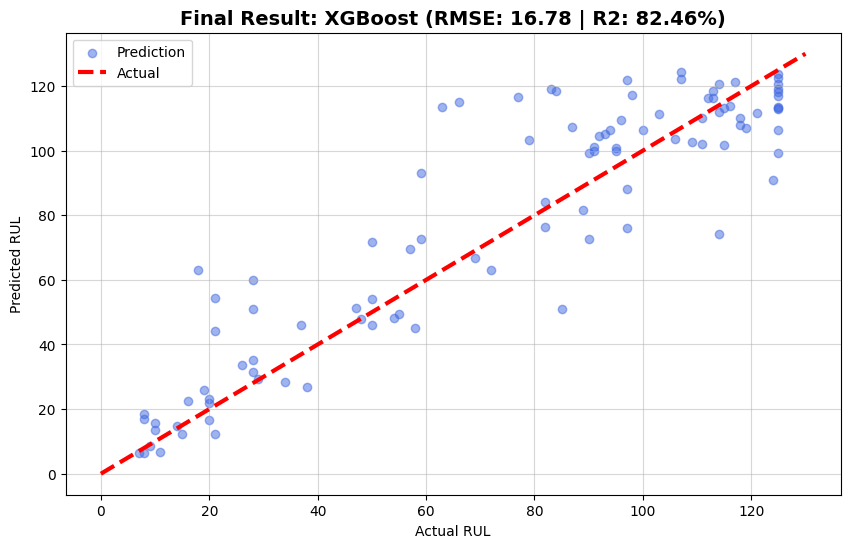

In [181]:
rmse_val = results[2]['RMSE']
r2_val = results[2]['R2']

plt.figure(figsize=(10, 6))

plt.scatter(y_test_true, y_pred_xgb, alpha=0.5, color='royalblue', label='Prediction')

plt.plot([0, 130], [0, 130], 'r--', linewidth=3, label='Actual')

plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title(f'Final Result: XGBoost (RMSE: {rmse_val:.2f} | R2: {r2_val:.2%})', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()